# AI4EO challenge: Air Quality & Health Challenge
## Run the code for South Africa - NO2

**Table of contents**

1. [Pre-processing](#pre-processing)

   1.1 [AOIs and target grids](#)
   
   1.2. [Training Data](#)
   
      1.2.1 [Input data & Auxiliary data](#)
      * [CAMS](#)
      * [S5P](#)
      * [Land cover](#) 
      * [ERA5](#)
      * [MODIS](#) 
      
   1.3 [Validation Data](#)
   
   1.3.1 [Input data & Auxiliary data](#)   
      * [CAMS](#)
      * [S5P](#)
      * [Land cover](#) 
      * [ERA5](#)
      * [MODIS](#) 
      
   1.4 [Target data - stations](#)

2. [Create training & validation data](#)

3. [Modelling and validation](#)

4. [Prediction](#)

5. [Calibration](#)

In [1]:
# Built-in modules
import os
import gzip
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import glob
import re


# Basics of Python data handling and visualization
import fs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from shapely import wkt
import rasterio as rio
from shapely import geometry
from rasterstats import zonal_stats
import seaborn as sns
import copy
import matplotlib.colors as colors
from matplotlib.patches import Patch

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate, GroupKFold, GridSearchCV
import statistics 
import joblib


# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType, AddFeature, MapFeatureTask, MergeFeatureTask, RemoveFeature,LoadTask, SaveTask, OverwritePermission
from sentinelhub import bbox_to_dimensions, bbox_to_resolution
from eolearn.io import ExportToTiff

# Visualisation utils
from utils import (get_extent, 
                   draw_outline, 
                   draw_bbox, 
                   draw_feature, 
                   draw_true_color,
                   unzip_file,
                   load_tiffs,
                   load_list_tiffs,
                   days_to_datetimes,
                   datetimes_to_days,
                   reproject_tiff,
                   upscale_tiff,
                   mask_tiff)

# MEOTEQ utils
from utils_meoteq import (create_grid,stats_cams,resample_cams_to_target, resample_s5p_to_target,reclassify_land_cover,reclassify_legend,masking_tiff,
                          land_cover_stats,stats_era5,resample_era5_to_target,resample_modis_to_target,extract_data,target_img, stats, 
                          filter_MODIS, modis_stats, fill_modis_gaps, export_s5p_band,polygrid, export_geotiff,percs_landuse, upscale_mean_tiff, 
                          extract_points_from_raster, extract_points_from_modis,extract_points_from_timeless_raster,extract_points_from_era5,upscale_nearest_tiff)

from create_dataset import create_dataset
from calibration import calibrate

# Pre-processing

Change this for the three provided AOIs. The data sources and data structure is consistent across AOIs. The AOIs are as follows:

* `training_dataset_ita`, `validation_dataset_ita` - `Italy`
* `training_dataset_usa`, `validation_dataset_usa` - `California`
* `training_dataset_south_africa`, `validation_dataset_south_africa` - `South_Africa`

In [2]:
DATA_DIR_TRAIN = Path('training_dataset_south_africa')
DATA_DIR_VAL = Path('validation_dataset_south_africa')
AOIS = ['South_Africa']
OFFSET = 2100

Change to the model that you want to build
* NO2
* PM2_5

In [3]:
# CHANGE THIS VALUE to 'PM2_5' or 'NO2 base on the model that you want to build
model = 'NO2'

In [4]:
## Select the target resoltion of CAMS based on AOI - "t" variable willl be used to rename resapmled inputs 
if model == 'NO2':
    t = 1 # target resolution 1 km
elif model == 'PM2_5':
    if AOIS[0] == 'Italy':
        t = 1 # target resolution 1 km
    else:
        t = 10 # target resolution 10 km
    

#### AOIs and target grids

In [5]:
if model == 'NO2':
    ## Load S5P NO2 data
    s5p_train_dir = DATA_DIR_TRAIN/AOIS[0]/'sentinel5P'
    train_eop = load_tiffs(s5p_train_dir/'NO2', (FeatureType.DATA, 'NO2'), offset=OFFSET)
    
    ## This function will create grid with target resolution for pixels corresponding to NO2
    orig_grid, orig_centroids, target_grid, target_centroids = create_grid(eopatch= train_eop, model=model, AOI=AOIS[0])
    

elif model == 'PM2_5':
    ## load CAMS PM2_5 data
    cams_train_dir = DATA_DIR_TRAIN/AOIS[0]/'CAMS'
    train_eop = load_tiffs(cams_train_dir/'PM2_5', 
                                (FeatureType.DATA, 'PM2_5'), 
                                offset=OFFSET,
                                data_source='cams')
    
    ## This function will create grid with target resolution for pixels corresponding to PM2_5
    orig_grid, orig_centroids, target_grid, target_centroids = create_grid(eopatch= train_eop, model=model, AOI=AOIS[0])



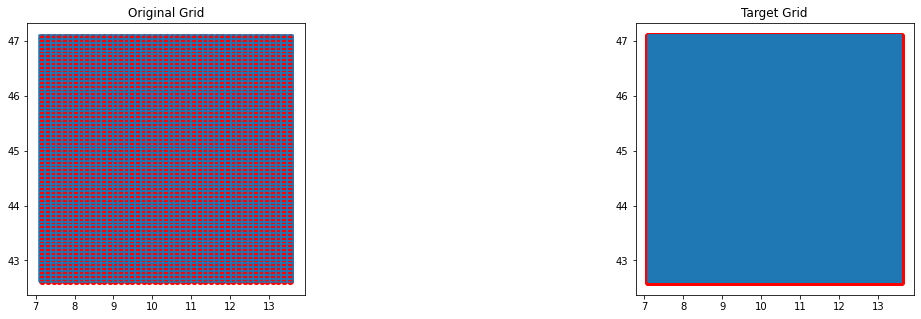

In [45]:
## Plot the grids
fig, axes = plt.subplots(ncols=2, figsize=(20,5))

p1 = orig_grid.boundary.plot(ax=axes[0])
orig_centroids.plot(ax=p1, color='red')
p1.set_title('Original Grid')

p2 = target_grid.boundary.plot(ax=axes[1])
target_centroids.plot(ax=p2, color='red')
p2.set_title('Target Grid')

plt.show()

## Preprocessing Training data

### CAMS

In [ ]:
# Read CAMS data
cams_train_dir = DATA_DIR_TRAIN/AOIS[0]/'CAMS'
cams_products = sorted(os.listdir(cams_train_dir))

cams_eops = [load_tiffs(cams_train_dir/cams_p, 
                        (FeatureType.DATA, cams_p), 
                        offset=OFFSET,
                        data_source='cams') 
             for cams_p in cams_products]

cams_eop = EOPatch(data={'NO2_surface': cams_eops[0].data['NO2_surface'], 
                         'PM2_5': cams_eops[1].data['PM2_5']},
                   meta_info={'Names_NO2_surface': cams_eops[0].meta_info['Names'],
                              'Names_PM2_5': cams_eops[1].meta_info['Names']},
                     timestamp=cams_eops[0].timestamp,
                     bbox=cams_eops[0].bbox)
del cams_eops

# Remove invalid pixels
NO_DATA_VALUE = -999.0
cams_eop.data['PM2_5'][cams_eop.data['PM2_5'] == NO_DATA_VALUE] = np.nan
cams_eop.data['NO2_surface'][cams_eop.data['NO2_surface'] == NO_DATA_VALUE] = np.nan

In [ ]:
# Merge hourly CAMS data, compute daily mean, maximum, minimum and standard deviation of CAMS products and export them 
output_path = str(DATA_DIR_TRAIN/AOIS[0])+'/daily'
stats_cams(eopatch = cams_eop, 
           cams_products=cams_products,
           out_path=output_path)

# Resample daily statistics CAMS to target resolution & same bounding box of target grid (NO2 or PM2.5) - the target resolution will assign automatically based on AOI
in_path = str(DATA_DIR_TRAIN/AOIS[0])+'/daily'
out_path = str(DATA_DIR_TRAIN/AOIS[0])+f'/{model}_data/daily'

resample_cams_to_target(target_bbox=train_eop.bbox,  # Bounding box of eopatch data (PM 2.5 , NO2) 
                        AOI=AOIS[0],                 # Area of interest       
                        model=model,                 # Model (PM2.5, NO2)
                        in_path=in_path,             # Path of directory where CAMS data are stored
                        out_path=out_path            # Path of directory where to save the new resampled CAMS data
                       )


In [6]:
# Read preprocessed resampled mean CAMS data        
cams_train_dir = DATA_DIR_TRAIN/AOIS[0]/f'{model}_data/daily/resampled_mean_cams_{t}km'
cams_products = sorted(os.listdir(cams_train_dir))

cams_train_eops = [load_tiffs(cams_train_dir/cams_p, 
                        (FeatureType.DATA, cams_p), 
                        offset=OFFSET,
                        data_source='cams') 
             for cams_p in cams_products]

cams_train_eop = EOPatch(data={'NO2_surface': cams_train_eops[0].data['NO2_surface'], 
                         'PM2_5': cams_train_eops[1].data['PM2_5']},
                   meta_info={'Names_NO2_surface': cams_train_eops[0].meta_info['Names'],
                              'Names_PM2_5': cams_train_eops[1].meta_info['Names']},
                     timestamp=cams_train_eops[0].timestamp,
                     bbox=cams_train_eops[0].bbox)
del cams_train_eops

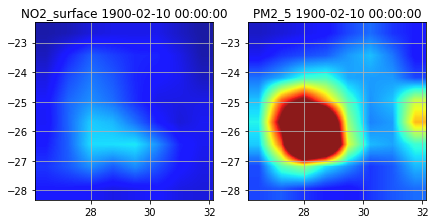

In [7]:
fig, axs = plt.subplots(figsize=(7, 6), ncols=len(cams_products))

time_idx = 0

normalisations = [dict(vmin=0, vmax=0.0000001), 
                  dict(vmin=0, vmax=80)]

for nn, (fname, norm) in enumerate(zip(cams_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=cams_train_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)

### S5P - NO2 & UV Aerosol Index

In [9]:
# Load S5P data NO2 & UV Aerosol Index
s5p_train_dir = DATA_DIR_TRAIN/AOIS[0]/'sentinel5P'
s5p_products = sorted(os.listdir(s5p_train_dir))

s5p_eops = [load_tiffs(s5p_train_dir/s5p_p, (FeatureType.DATA, s5p_p), offset=OFFSET) 
           for s5p_p in s5p_products]

s5p_eop = EOPatch(data={'NO2': s5p_eops[0].data['NO2'], 
                        'UV_AEROSOL_INDEX': s5p_eops[1].data['UV_AEROSOL_INDEX']},
                  meta_info={'Names_NO2': s5p_eops[0].meta_info['Names'],
                             'Names_UV_AEROSOL_INDEX': s5p_eops[1].meta_info['Names']},
                  timestamp=s5p_eops[0].timestamp,
                  bbox=s5p_eops[0].bbox)
del s5p_eops

# Filter the bands to build the model using just high quality pixles 
## set no values to nan
NO_DATA_VALUE = -9999
s5p_eop.data['UV_AEROSOL_INDEX'][s5p_eop.data['UV_AEROSOL_INDEX'] == NO_DATA_VALUE] = np.nan
s5p_eop.data['NO2'][s5p_eop.data['NO2'] == NO_DATA_VALUE] = np.nan

## Use Qa band to reduce noisy observations, using Qa threshold 
min_q_a = 50
s5p_eop.data['UV_AEROSOL_INDEX'][..., 0][s5p_eop.data['UV_AEROSOL_INDEX'][..., 1] <= min_q_a] = np.nan
s5p_eop.data['NO2'][..., 0][s5p_eop.data['NO2'][..., 1] <= min_q_a] = np.nan

In [10]:
# Extract bands after filitering them, and export them to same bounding box
##This is important step to make sure the tiles are coincide

## location of exported tiff
filtered_s5p_dir = str(DATA_DIR_TRAIN/AOIS[0])+'/filtered_s5p'
if not os.path.isdir(filtered_s5p_dir):
    os.makedirs(filtered_s5p_dir)

## This function to export filtered bands to the same bounding box
export_s5p_band(s5p_eop,
               s5p_products = s5p_products,
               path = filtered_s5p_dir)

In [11]:
## lOAD FILTERED S5P products
s5p_train_dir = DATA_DIR_TRAIN/AOIS[0]/'filtered_s5p'
s5p_products = sorted(os.listdir(s5p_train_dir))

s5p_eops = [load_tiffs(s5p_train_dir/s5p_p, (FeatureType.DATA, s5p_p), offset=OFFSET) 
           for s5p_p in s5p_products]

s5p_eop = EOPatch(data={'NO2': s5p_eops[0].data['NO2'], 
                        'UV_AEROSOL_INDEX': s5p_eops[1].data['UV_AEROSOL_INDEX']},
                  meta_info={'Names_NO2': s5p_eops[0].meta_info['Names'],
                             'Names_UV_AEROSOL_INDEX': s5p_eops[1].meta_info['Names']},
                  timestamp=s5p_eops[0].timestamp,
                  bbox=s5p_eops[0].bbox)
del s5p_eops

In [12]:
# Merge hourly S5P data & compute daily mean
## creat dircetory for the daily statistcs
mean_filtered_s5p_dir = str(DATA_DIR_TRAIN/AOIS[0])+f'/daily/mean_filtered_s5p'
if not os.path.isdir(mean_filtered_s5p_dir):
    os.makedirs(mean_filtered_s5p_dir)
    for s5p_p in s5p_products:
        os.mkdir(mean_filtered_s5p_dir + '/' + s5p_p)

## Apply the stats function on S5P products and export the result
for s5p_p in s5p_products:
    stats(eopatch=s5p_eop,
          product = s5p_p,
         stats = 'mean',
         out_path= mean_filtered_s5p_dir)
    
## Resample daily mean S5P to target resolution and same bounding box of target grid (NO2 or PM2.5) - the target resolution will assign automatically based on AOI 
in_path = str(DATA_DIR_TRAIN/AOIS[0])+f'/daily/mean_filtered_s5p'
out_path = str(DATA_DIR_TRAIN/AOIS[0])+f'/{model}_data/daily'
resample_s5p_to_target(target_bbox=train_eop.bbox,
                       AOI=AOIS[0],
                       model=model,
                       in_path=in_path,
                       out_path=out_path)

In [9]:
## Load resampled s5p products
s5p_train_dir = DATA_DIR_TRAIN/AOIS[0]/f'{model}_data/daily/resampled_s5p_{t}km'
s5p_products = sorted(os.listdir(s5p_train_dir))

s5p_train_eops = [load_tiffs(s5p_train_dir/s5p_p, (FeatureType.DATA, s5p_p), offset=OFFSET) 
           for s5p_p in s5p_products]

s5p_train_eop = EOPatch(data={'NO2': s5p_train_eops[0].data['NO2'], 
                        'UV_AEROSOL_INDEX': s5p_train_eops[1].data['UV_AEROSOL_INDEX']},
                  meta_info={'Names_NO2': s5p_train_eops[0].meta_info['Names'],
                             'Names_UV_AEROSOL_INDEX': s5p_train_eops[1].meta_info['Names']},
                  timestamp=s5p_train_eops[0].timestamp,
                  bbox=s5p_train_eops[0].bbox)
del s5p_train_eops

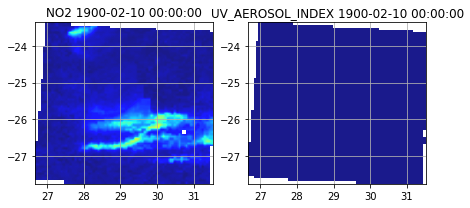

In [10]:
# Draw a sample
fig, axs = plt.subplots(figsize=(7, 6), ncols=len(s5p_products))

time_idx = 0

normalisations = [dict(vmin=0, vmax=0.0006), 
                  dict(vmin=4, vmax=6)]

for nn, (fname, norm) in enumerate(zip(s5p_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=s5p_train_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)

### Land cover

Change the name of landcover of AOIs. The AOIs are as follows:

* `Copernicus_Global_Land_Cover_W140N40_california.tif` - `California`
* `U2018_CLC2018_V2020_20u1_North_Italy` - `Italy`
* `SANLC_2018_africa.tif` - `South_Africa`

In [12]:
land_cover_file = 'land_cover' # corine for Italy , land_cover for Italy & South Africa
number_of_classes= 4 #  Reclassify the land cover - change this value based on AOI (Italy:5, South Africa:4, California:4)

In [ ]:
# Read data (CRS: 4326)
land_cover_train_dir = DATA_DIR_TRAIN/AOIS[0]/f'{land_cover_file}'
land_cover_name = 'SANLC_2018_africa.tif' 

## Reproject to WGS84
if AOIS[0] == 'Italy':
    reproject_tiff(f'{land_cover_train_dir}/{land_cover_name}.tif',
               f'{land_cover_train_dir}/{land_cover_name}_wgs84.tif', 
               dst_crs = 'EPSG:4326')
    land_cover_name = land_cover_name + '_wgs84.tif'
    


feature_name = 'LC'
land_cover_eop = load_tiffs(datapath=land_cover_train_dir,
                            feature=(FeatureType.MASK_TIMELESS, feature_name), 
                            filename= land_cover_name,
                            image_dtype=np.uint8,
                            no_data_value=0)

# This function to reclassify Land cover to 4 or 5 classes (Urban, Natural, Water, Agriculture, industrial) based on the available classes in Land cover tile of AOI
## Reclassify Italy into 5 classes (Urban, Natural, Water, Agriculture, industrial)
## Reclassify South_Africa into 4 classes (Industrial,Urban, Natural,Agriculture)
## Reclassify Califorina into 4 classses (water,Urban, Natural,Agriculture)

reclassify_land_cover(eopatch=land_cover_eop,
                      feature_name = feature_name,
                      AOI=AOIS[0],
                      land_cover_path=land_cover_train_dir,
                      land_cover_name=land_cover_name, 
                      number_of_classes=number_of_classes,
                      out_name='LC')

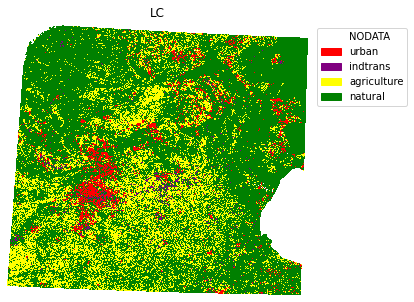

In [13]:
# Load reclassified Land cover

land_cover_train_dir = DATA_DIR_TRAIN/AOIS[0]/f'{land_cover_file}'
feature_name_LC = 'LC'  ## Name of masked_timesless data in the "land cover" eopatch

land_cover_eop = load_tiffs(datapath=land_cover_train_dir,
                            feature=(FeatureType.MASK_TIMELESS, feature_name_LC), 
                            filename= 'LC.tif',
                            image_dtype=np.uint8,
                            no_data_value=0)

# Plot reclassified Land cover
## This function to load legend for the reclassifed land cover
cmap, legend_labels = reclassify_legend(AOI=AOIS[0])

## Create patches
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

## Plot reclassified land cover
fig, ax = plt.subplots(figsize=(10,5))

fh = draw_feature(ax=ax, eopatch=land_cover_eop, 
                  feature=(FeatureType.MASK_TIMELESS, 'LC'), 
                  time_idx=None, 
                  cmap=cmap,
                  vmin=0, vmax=number_of_classes)
ax.legend(handles=patches,
          bbox_to_anchor=(1.35, 1),
          facecolor="white")
ax.set_axis_off()
plt.show()




This step may takes time 

In [10]:
# Calculate the percentage of each land cover class inside each pixel - using the target grid
## Peroform Zonal statistics using the target grid (1km or 10km) to calculate the perectage of land cover classes inside each pixel 
## Then the function will compute the percentage of land cover classes within 50 km around each pixel " Zonal statistics - ~50km"
## In final we will have two raster for each land cover class 


### Create direcory to export the zonal stats of land cover to it
land_cover_stats_dir = str(land_cover_train_dir)+f'/zonal_stats/{model}'
if not os.path.isdir(land_cover_stats_dir):
    os.makedirs(land_cover_stats_dir)

LC_grid = land_cover_stats(eopatch=land_cover_eop,              # EOPatch for reclassified landcover
                           feature_name = feature_name_LC,      # Name of mask timeless data (reclassified land cover layer) in the eopatch (feature_name_LC = 'LC')
                           target_grid = target_grid ,          # Grid of training data at target resolution
                           target_centroids = target_centroids, # Centroids of grid of training data at target resolution
                           target_bbox = train_eop.bbox,        # Bounding box of NO2/PM2.5 EOPatch  (min_x, max_x, min_y, max_y)
                           AOI= AOIS[0],                        # Area of intrest
                           model=model,                         # Model (PM2_5, NO2)
                           land_cover_path= land_cover_train_dir, # path of reclassified land cover
                           land_cover_name='LC.tif',            # name of exported reclassified land cover
                           out_path= land_cover_stats_dir       # path of exported tiff
                          )



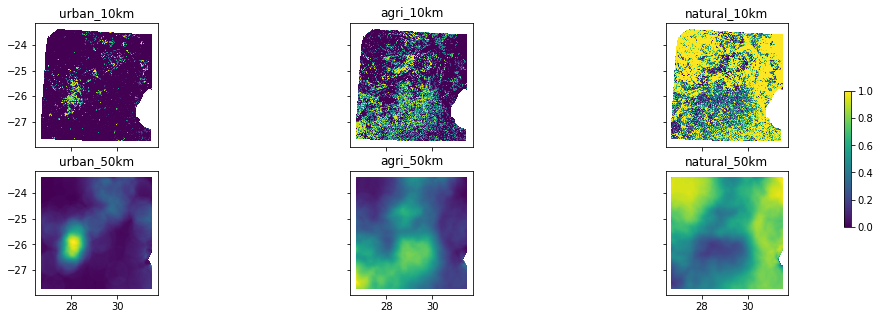

In [90]:
## Plot samples of zonal statistics land cover
fig, axs = plt.subplots(ncols=3,nrows=2, sharex=True, sharey=True, figsize=(20,5))

LC_grid.plot(ax=axs[0,0], column=f'urban_{t}km')
axs[0,0].set_title(f'urban_{t}km')
LC_grid.plot(ax=axs[1,0], column='urban_50km')
axs[1,0].set_title('urban_50km')


LC_grid.plot(ax=axs[0,1], column=f'agri_{t}km')
axs[0,1].set_title(f'agri_{t}km')
LC_grid.plot(ax=axs[1,1], column='agri_50km')
axs[1,1].set_title('agri_50km')


LC_grid.plot(ax=axs[0,2], column=f'natural_{t}km')
axs[0,2].set_title(f'natural_{t}km')
LC_grid.plot(ax=axs[1,2], column='natural_50km')
axs[1,2].set_title('natural_50km')

patch_col = axs[0,0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.5)

### ERA5

In [ ]:
# Load data
era5_train_dir = DATA_DIR_TRAIN/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_train_dir))
era5_eops = [load_tiffs(Path(era5_train_dir)/era5_p, 
                        (FeatureType.DATA, era5_p), 
                        offset=OFFSET, 
                        image_dtype=np.float32,
                        data_source='era5') 
             for era5_p in era5_products]

# Merge into one EOPS
era5_eop = EOPatch(data={'relative_humidity': era5_eops[0].data['relative_humidity'], 
                              'specific_rain_water_content': era5_eops[1].data['specific_rain_water_content'],
                              'wind_u': era5_eops[2].data['wind_u'],
                              'wind_v': era5_eops[3].data['wind_v']},
                        meta_info={'Names_relative_humidity': era5_eops[0].meta_info['Names'],
                                   'Names_specific_rain_water_content':era5_eops[1].meta_info['Names'],
                                   'Names_wind_u': era5_eops[2].meta_info['Names'],
                                   'Names_wind_v': era5_eops[3].meta_info['Names']},
                        timestamp= era5_eops[0].timestamp,
                        bbox= era5_eops[0].bbox)

del era5_eops

## Remove invalid pixels
NO_DATA_VALUE = -32767

era5_eop.data['relative_humidity'][era5_eop.data['relative_humidity'] == NO_DATA_VALUE] = np.nan
era5_eop.data['specific_rain_water_content'][era5_eop.data['specific_rain_water_content'] == NO_DATA_VALUE] = np.nan
era5_eop.data['wind_u'][era5_eop.data['wind_u'] == NO_DATA_VALUE] = np.nan
era5_eop.data['wind_v'][era5_eop.data['wind_v'] == NO_DATA_VALUE] = np.nan

In [40]:
# This function to merge ERA5 products, compute daily mean of ('relative_humidity', 'wind_u', 'wind_v') and daily summation of "specific_rain_water_content"

## location of exported daily mean of ERA5
mean_era5_dir = str(DATA_DIR_TRAIN/AOIS[0])+'/daily/mean_era5'

## Run merge function
stats_era5(eopatch= era5_eop,
           era5_products= era5_products,
           out_path= mean_era5_dir)

In [43]:
## Resample merged ERA5 to target resolution and same bounding box of target grid (NO2 or PM2.5) - the target resolution will assign automatically based on AOI 
in_path = str(DATA_DIR_TRAIN/AOIS[0])+'/daily/mean_era5'
out_path = str(DATA_DIR_TRAIN/AOIS[0])+f'/{model}_data/daily'
resample_era5_to_target(target_bbox=train_eop.bbox,
                       AOI=AOIS[0],
                       model=model,
                       in_path=in_path,
                       out_path=out_path)

In [15]:
## Read preprocessed ERA5 
preproc_era5_location = DATA_DIR_TRAIN/AOIS[0]/f'{model}_data/daily/resampled_era5_{t}km'
era5_products = sorted(os.listdir(preproc_era5_location))

# Load data
era5_train_eops = [load_tiffs(preproc_era5_location/era5_p, 
                        (FeatureType.DATA, era5_p), 
                        offset=OFFSET, 
                        image_dtype=np.float32,
                        data_source='era5') 
             for era5_p in era5_products]

# Merge into one EOPS
era5_train_eop = EOPatch(data={'relative_humidity': era5_train_eops[0].data['relative_humidity'], 
                              'specific_rain_water_content': era5_train_eops[1].data['specific_rain_water_content'],
                              'wind_u': era5_train_eops[2].data['wind_u'],
                              'wind_v': era5_train_eops[3].data['wind_v']},
                        meta_info={'Names_relative_humidity': era5_train_eops[0].meta_info['Names'],
                                   'Names_specific_rain_water_content':era5_train_eops[1].meta_info['Names'],
                                   'Names_wind_u': era5_train_eops[2].meta_info['Names'],
                                   'Names_wind_v': era5_train_eops[3].meta_info['Names']},
                        timestamp= era5_train_eops[0].timestamp,
                        bbox= era5_train_eops[0].bbox)
del era5_train_eops

# IMPORTANT! Missing water pixels are 0. They must be assigned
era5_train_eop.data['specific_rain_water_content'][np.isnan(era5_train_eop.data['specific_rain_water_content'])] = 0

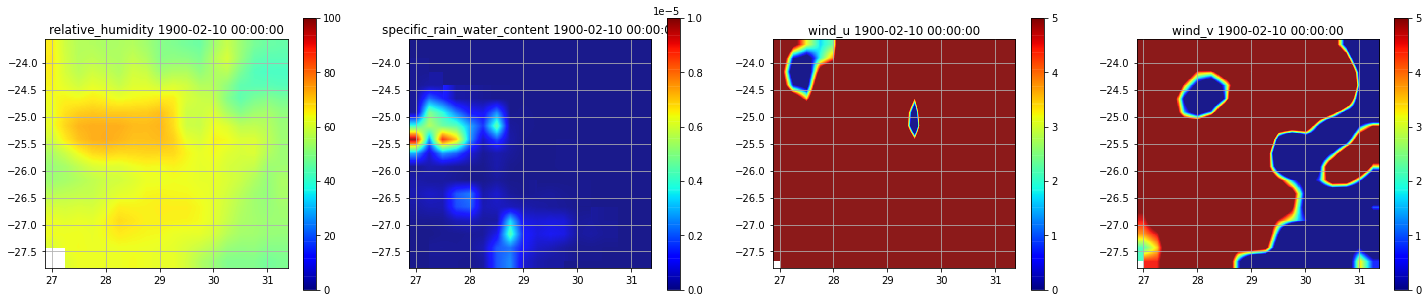

In [16]:
## Plot preprocessed ERA5 
fig, axs = plt.subplots(figsize=(25, 5), ncols=4)

time_idx = 0

normalisations = [dict(vmin=0, vmax=100), dict(vmin=0, vmax=0.00001), dict(vmin=0, vmax=5), dict(vmin=0, vmax=5)]

for nn, (fname, norm) in enumerate(zip(era5_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=era5_train_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

### MODIS

In [46]:
modis_train_dir = DATA_DIR_TRAIN/AOIS[0]/'modis_MCD19A2'
modis_products = sorted(os.listdir(modis_train_dir))

## Load MODIS AOD - Aerosol Optical depth information
modis_eops = [load_tiffs(datapath=modis_train_dir/'MCD19A2_AOD',
                         feature=(FeatureType.DATA, 'AOD'),
                         filename=filename,
                         image_dtype=np.float32,
                         data_source='modis') 
              for filename in sorted(os.listdir(modis_train_dir/'MCD19A2_AOD'))]

## Load MODIS AOD - Optical Depth Quality Index
modis_qa_eops = [load_tiffs(datapath=modis_train_dir/'MCD19A2_AOD_QA',
                            feature=(FeatureType.DATA, 'AOD_QA'),
                            filename=filename,
                            image_dtype=np.float32,
                            data_source='modis') 
                 for filename in sorted(os.listdir(modis_train_dir/'MCD19A2_AOD_QA'))]

In [47]:
#In this step we filtered MODIS pixels & calculate daily statistcs (mean, maximum, minimum) 

# This function to filtere low quailty MODIS pixels using Optical Depth Quality Index band
filter_MODIS(modis_eops,modis_qa_eops)

# This function to Compute Statistics of MODIS to derive a single daily observation (mean, maximum, minimum)
## location of exported statisitcs MODIS
modis_products = ['daily_mean_AOD','daily_maximum_AOD','daily_minimum_AOD']
statistics_modis_dir = str(DATA_DIR_TRAIN/AOIS[0])+'/daily/statistics_modis'
if not os.path.isdir(statistics_modis_dir):
    os.makedirs(statistics_modis_dir)
    for modis_p in modis_products:
        os.mkdir(statistics_modis_dir + '/' + modis_p)
        
## Run the function to compute statistics MODIS function and export the statistics tiff to a specific directory 
modis_stats(modis_eops, path = statistics_modis_dir)

In [48]:
## Load the daily statistcs MODIS products
modis_eops = [load_tiffs(Path(statistics_modis_dir)/modis, 
                               (FeatureType.DATA, modis),
                               image_dtype=np.float32,
                               data_source='modis')
                    for modis in modis_products]

## Merge them into a single EOPatch
modis_eop = EOPatch(data={'daily_mean_AOD': modis_eops[0].data['daily_mean_AOD'], 
                         'daily_maximum_AOD': modis_eops[1].data['daily_maximum_AOD'],
                               'daily_minimum_AOD': modis_eops[2].data['daily_minimum_AOD'],},
                          meta_info={'tiff_names': modis_eops[0].meta_info['Names']},
                              timestamp=modis_eops[0].timestamp,
                              bbox=modis_eops[0].bbox)
del modis_eops

In [49]:
# This step will fill the mssing pixels in MODIS as following :
## 1- Fill the missing pixels using temporal linear interpolation  
## 2- Loop into the eopatch and asssign the mean value of MODIS observations to the remaining missing pixels
## 3- export the filling MODIS band "Optical_Depth_047" to specific directory

### location of exported filled MODIS band "Optical_Depth_047"
modis_products = ['daily_mean_AOD','daily_maximum_AOD','daily_minimum_AOD']

filled_modis_AOD = str(DATA_DIR_TRAIN/AOIS[0])+'/daily/filled_stats_modis'
if not os.path.isdir(filled_modis_AOD):
    os.makedirs(filled_modis_AOD)
    for modis_p in modis_products:
        os.mkdir(filled_modis_AOD + '/' + modis_p)
        
### Run the filling function
fill_modis_gaps(modis_eop, modis_products = modis_products, path=filled_modis_AOD)

In [50]:
## Resample daily statistcs MODIS products to target resolution and same bounding box of target grid (NO2 or PM2.5) - the target resolution will assign automatically based on AOI 
in_path = str(DATA_DIR_TRAIN/AOIS[0])+'/daily/filled_stats_modis'
out_path = str(DATA_DIR_TRAIN/AOIS[0])+f'/{model}_data/daily'

resample_modis_to_target(target_bbox=train_eop.bbox,
                       AOI=AOIS[0],
                       model=model,
                       in_path=in_path,
                       out_path=out_path)

In [18]:
# Load resampled MODIS data
modis_train_dir = str(DATA_DIR_TRAIN/AOIS[0])+f'/{model}_data/daily/resampled_modis_{t}km'
modis_products = sorted(os.listdir(modis_train_dir))

modis_train_eops = [load_tiffs(Path(modis_train_dir)/modis_p, 
                        (FeatureType.DATA, modis_p), 
                        image_dtype=np.float32,
                        data_source='modis')
             for modis_p in modis_products]

# Merge into one EOPS
modis_train_eop = EOPatch(data={'daily_maximum_AOD': modis_train_eops[0].data['daily_maximum_AOD'], 
                              'daily_mean_AOD': modis_train_eops[1].data['daily_mean_AOD'],
                              'daily_minimum_AOD': modis_train_eops[2].data['daily_minimum_AOD']},
                    
                        meta_info={'Names': modis_train_eops[0].meta_info['Names'],
                                   'Names':modis_train_eops[1].meta_info['Names'],
                                   'Names': modis_train_eops[2].meta_info['Names']},
                        timestamp= modis_train_eops[0].timestamp,
                        bbox= modis_train_eops[0].bbox)

del modis_train_eops

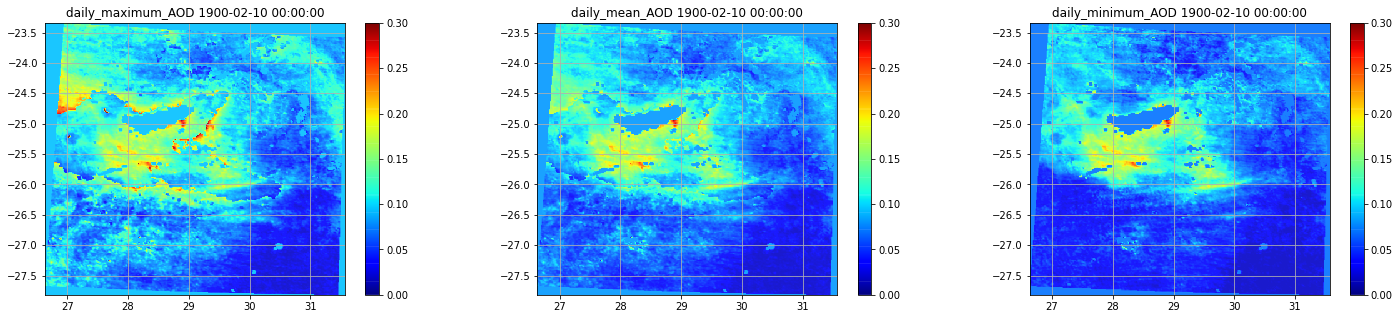

In [19]:
## Plot MODIS Data (mean,maximum,minimium)
fig, axs = plt.subplots(figsize=(25,5), ncols=3)

time_idx = 0



normalisations = [dict(vmin=0, vmax=0.3), dict(vmin=0, vmax=0.3), dict(vmin=0, vmax=0.3)]

for nn, (fname, norm) in enumerate(zip(modis_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=modis_train_eop, 
                      feature=(FeatureType.DATA, fname), 
                      **norm,
                      time_idx = time_idx,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

### Preprocessing Validation data

Another target grid created using the validation data to Pre-process the validation data, due to differences in bounding boxes between training and validation data

In [6]:
if model == 'NO2':
    ## Load S5P NO2 data
    s5p_val_dir = DATA_DIR_VAL/AOIS[0]/'sentinel5P'
    val_eop = load_tiffs(s5p_val_dir/'NO2', (FeatureType.DATA, 'NO2'), offset=OFFSET)
    
    ## This function will create grids with original resolution & target resolution for pixels corresponding to NO2
    val_orig_grid, val_orig_centroids, val_target_grid, val_target_centroids = create_grid(eopatch= val_eop, model=model, AOI=AOIS[0])
    

elif model == 'PM2_5':
    ## load CAMS PM2_5 data
    cams_val_dir = DATA_DIR_VAL/AOIS[0]/'CAMS'
    val_eop = load_tiffs(cams_val_dir/'PM2_5', 
                                (FeatureType.DATA, 'PM2_5'), 
                                offset=OFFSET,
                                data_source='cams')
    
    ## This function will create grid with original resolution & target resolution for pixels corresponding to PM2_5
    val_orig_grid, val_orig_centroids, val_target_grid, val_target_centroids = create_grid(eopatch= val_eop, model=model, AOI=AOIS[0])
    


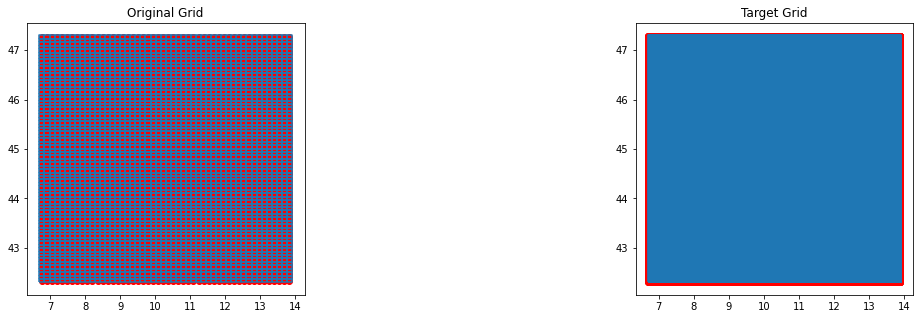

In [54]:
## Plot the grids
fig, axes = plt.subplots(ncols=2, figsize=(20,5))

p1 = val_orig_grid.boundary.plot(ax=axes[0])
val_orig_centroids.plot(ax=p1, color='red')
p1.set_title('Original Grid')

p2 = val_target_grid.boundary.plot(ax=axes[1])
val_target_centroids.plot(ax=p2, color='red')
p2.set_title('Target Grid')

plt.show()

#### Select predictors based on the target dates - then preprocess just the selected dates

Change 'AOI' variable for the three provided AOIs, as following:

* `Italy` - `Italy`
* `usa` - `California`
* `SA` - `South Africa`

In [6]:
AOI = 'SA' # 'Italy' for Italy, 'usa' for California, 'SA'  for South Africa

In [7]:
if model == 'NO2':
    # NO2 target dates
    dates = pd.read_csv(f'submission_date/{AOI}-date-NO2.txt')
    ## This function prepare the tiff names of predictors and target
    target_tiff_names = target_img(target_dates = dates, AOI=AOIS[0], model = model)


elif model == 'PM2_5':
    # CAMS dates
    dates = pd.read_csv(f'submission_date/{AOI}-date-PM25.txt')
    ## This function prepare the tiff names of predictors and target
    target_tiff_names = target_img(target_dates = dates, AOI=AOIS[0], model = model)
    
cams_pm25_tiffnames = target_tiff_names[0]
cams_no2_tiffnames = target_tiff_names[1]
s5p_no2_tiffnames = target_tiff_names[2]
s5p_uv_aerosol_tiffnames = target_tiff_names[3]
modis_tiffnames = target_tiff_names[4]
era5_tiffnames = target_tiff_names[5]

### CAMS

In [15]:
# Read CAMS data
cams_val_dir = DATA_DIR_VAL/AOIS[0]/'CAMS'
cams_products = sorted(os.listdir(cams_val_dir))

cams_eops = [load_tiffs(cams_val_dir/cams_p, 
                        (FeatureType.DATA, cams_p), 
                        offset=OFFSET,
                        data_source='cams') 
             for cams_p in cams_products]

cams_eop = EOPatch(data={'NO2_surface': cams_eops[0].data['NO2_surface'], 
                         'PM2_5': cams_eops[1].data['PM2_5']},
                   meta_info={'Names_NO2_surface': cams_eops[0].meta_info['Names'],
                              'Names_PM2_5': cams_eops[1].meta_info['Names']},
                     timestamp=cams_eops[0].timestamp,
                     bbox=cams_eops[0].bbox)
del cams_eops

# Remove invalid pixels
NO_DATA_VALUE = -999.0
cams_eop.data['PM2_5'][cams_eop.data['PM2_5'] == NO_DATA_VALUE] = np.nan
cams_eop.data['NO2_surface'][cams_eop.data['NO2_surface'] == NO_DATA_VALUE] = np.nan

In [16]:
# Merge hourly CAMS data, compute daily mean, maximum, minimum and standard deviation of CAMS products and export them 
output_path = str(DATA_DIR_VAL/AOIS[0])+'/daily'
stats_cams(eopatch = cams_eop, 
           cams_products=cams_products,
           out_path=output_path)

# Resample daily statistics CAMS to target resolution & same bounding box of target grid (NO2 or PM2.5) - the target resolution will assign automatically based on AOI
in_path = str(DATA_DIR_VAL/AOIS[0])+'/daily'
out_path = str(DATA_DIR_VAL/AOIS[0])+f'/{model}_data/daily'
resample_cams_to_target(target_bbox=val_eop.bbox,  # resample to target bounding box
                        AOI=AOIS[0],
                        model=model,
                        in_path=in_path,
                        out_path=out_path,
                       tiffnames=[cams_pm25_tiffnames,cams_no2_tiffnames] # target dates of CAMS products
                       )

In [24]:
# Read preprocessed resampled mean CAMS data        
cams_val_dir = DATA_DIR_VAL/AOIS[0]/f'{model}_data/daily/resampled_mean_cams_{t}km'
cams_products = sorted(os.listdir(cams_val_dir))

cams_val_eops = [load_tiffs(cams_val_dir/cams_p, 
                        (FeatureType.DATA, cams_p), 
                        offset=OFFSET,
                        data_source='cams') 
             for cams_p in cams_products]

cams_val_eop = EOPatch(data={'NO2_surface': cams_val_eops[0].data['NO2_surface'], 
                         'PM2_5': cams_val_eops[1].data['PM2_5']},
                   meta_info={'Names_NO2_surface': cams_val_eops[0].meta_info['Names'],
                              'Names_PM2_5': cams_val_eops[1].meta_info['Names']},
                     timestamp=cams_val_eops[0].timestamp,
                     bbox=cams_val_eops[0].bbox)
del cams_val_eops

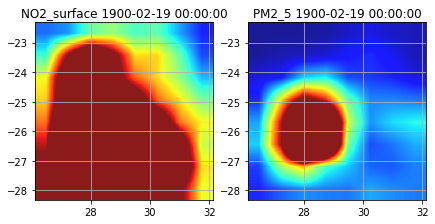

In [25]:
fig, axs = plt.subplots(figsize=(7, 6), ncols=len(cams_products))

time_idx = 0

normalisations = [dict(vmin=0, vmax=0.00000001), 
                  dict(vmin=0, vmax=80)]

for nn, (fname, norm) in enumerate(zip(cams_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=cams_val_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)

### S5P - NO2 & UV Aerosol Index

In [8]:
# Load S5P data NO2 & UV Aerosol Index
s5p_val_dir = DATA_DIR_VAL/AOIS[0]/'sentinel5P'
s5p_products = sorted(os.listdir(s5p_val_dir))

s5p_eops = [load_tiffs(s5p_val_dir/s5p_p, (FeatureType.DATA, s5p_p), offset=OFFSET) 
           for s5p_p in s5p_products]

s5p_eop = EOPatch(data={'NO2': s5p_eops[0].data['NO2'], 
                        'UV_AEROSOL_INDEX': s5p_eops[1].data['UV_AEROSOL_INDEX']},
                  meta_info={'Names_NO2': s5p_eops[0].meta_info['Names'],
                             'Names_UV_AEROSOL_INDEX': s5p_eops[1].meta_info['Names']},
                  timestamp=s5p_eops[0].timestamp,
                  bbox=s5p_eops[0].bbox)
del s5p_eops

# Filter the bands to build the model using just high quality pixles 
## set no values to nan
NO_DATA_VALUE = -9999
s5p_eop.data['UV_AEROSOL_INDEX'][s5p_eop.data['UV_AEROSOL_INDEX'] == NO_DATA_VALUE] = np.nan
s5p_eop.data['NO2'][s5p_eop.data['NO2'] == NO_DATA_VALUE] = np.nan

In [9]:
# Extract NO2 & UV Aerosol Index bands (without Qa bands) and export them to same bounding box
##This is important step to make sure the tiles are coincide

## location of exported tiff
original_s5p_dir = str(DATA_DIR_VAL/AOIS[0])+'/original_s5p'
if not os.path.isdir(original_s5p_dir):
    os.makedirs(original_s5p_dir)

## This function to export the bands to the same bounding box
export_s5p_band(s5p_eop,
               s5p_products = s5p_products,
               path = original_s5p_dir)

In [10]:
## lOAD S5P data
s5p_val_dir = DATA_DIR_VAL/AOIS[0]/'original_s5p'
s5p_products = sorted(os.listdir(s5p_val_dir))

s5p_eops = [load_tiffs(s5p_val_dir/s5p_p, (FeatureType.DATA, s5p_p), offset=OFFSET) 
           for s5p_p in s5p_products]

s5p_eop = EOPatch(data={'NO2': s5p_eops[0].data['NO2'], 
                        'UV_AEROSOL_INDEX': s5p_eops[1].data['UV_AEROSOL_INDEX']},
                  meta_info={'Names_NO2': s5p_eops[0].meta_info['Names'],
                             'Names_UV_AEROSOL_INDEX': s5p_eops[1].meta_info['Names']},
                  timestamp=s5p_eops[0].timestamp,
                  bbox=s5p_eops[0].bbox)
del s5p_eops

In [11]:
# Merge hourly S5P data & compute daily mean
## creat dircetory for the daily statistcs
mean_s5p_dir = str(DATA_DIR_VAL/AOIS[0])+f'/daily/mean_s5p'
if not os.path.isdir(mean_s5p_dir):
    os.makedirs(mean_s5p_dir)
    for s5p_p in s5p_products:
        os.mkdir(mean_s5p_dir + '/' + s5p_p)

## Apply the stats function on S5P products and export the result
for s5p_p in s5p_products:
    stats(eopatch=s5p_eop,
          product = s5p_p,
         stats = 'mean',
         out_path= mean_s5p_dir)
    
## Resample daily S5P to target resolution and same bounding box of target grid (NO2 or PM2.5) - the target resolution will assign automatically based on AOI 
in_path = str(DATA_DIR_VAL/AOIS[0])+f'/daily/mean_s5p'
out_path = str(DATA_DIR_VAL/AOIS[0])+f'/{model}_data/daily'

resample_s5p_to_target(target_bbox=val_eop.bbox,  # resample to target bounding box
                       AOI=AOIS[0],
                       model=model,
                       in_path=in_path,
                       out_path=out_path,
                      tiffnames=[s5p_no2_tiffnames, s5p_uv_aerosol_tiffnames] # target dates of S5P products
                      )

In [12]:
## Load resampled s5p products
s5p_val_dir = DATA_DIR_VAL/AOIS[0]/f'{model}_data/daily/resampled_s5p_{t}km'
s5p_products = sorted(os.listdir(s5p_val_dir))

s5p_val_eops = [load_tiffs(s5p_val_dir/s5p_p, (FeatureType.DATA, s5p_p), offset=OFFSET) 
           for s5p_p in s5p_products]

s5p_val_eop = EOPatch(data={'NO2': s5p_val_eops[0].data['NO2'], 
                        'UV_AEROSOL_INDEX': s5p_val_eops[1].data['UV_AEROSOL_INDEX']},
                  meta_info={'Names_NO2': s5p_val_eops[0].meta_info['Names'],
                             'Names_UV_AEROSOL_INDEX': s5p_val_eops[1].meta_info['Names']},
                  timestamp=s5p_val_eops[0].timestamp,
                  bbox=s5p_val_eops[0].bbox)
del s5p_val_eops

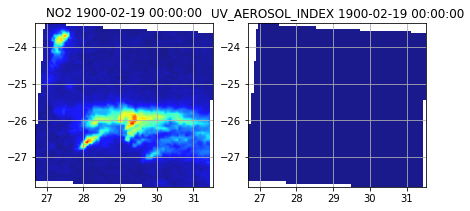

In [32]:
# Draw a sample
fig, axs = plt.subplots(figsize=(7, 6), ncols=len(s5p_products))

time_idx = 0

normalisations = [dict(vmin=0, vmax=0.0006), 
                  dict(vmin=4, vmax=6)]

for nn, (fname, norm) in enumerate(zip(s5p_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=s5p_val_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)

### Land cover

The same process of preparing trainin data, but using validation grid because the validation & training data have different size and bounding box.
* This step may takes time.

In [7]:
land_cover_file = 'land_cover' # corine for Italy , land_cover for California & South Africa

In [9]:
## Read reclassified land cover (CRS: 4326)
land_cover_val_dir = DATA_DIR_TRAIN/AOIS[0]/f'{land_cover_file}'

land_cover_eop = load_tiffs(datapath=land_cover_val_dir,
                            feature=(FeatureType.MASK_TIMELESS, 'LC'), 
                            filename='LC.tif', # the name of exported reclassified land cover (land_cover_name='LC.tif') 
                            image_dtype=np.uint8,
                            no_data_value=0)

In [11]:
### Create direcory to export the zonal stats of land cover to it
feature_name_LC = 'LC'  ## Name of masked_timesless data in the "land cover" eopatch

land_cover_stats_dir = str(DATA_DIR_VAL/AOIS[0])+f'/{land_cover_file}/zonal_stats/{model}'
if not os.path.isdir(land_cover_stats_dir):
    os.makedirs(land_cover_stats_dir)
    
LC_grid = land_cover_stats(eopatch=land_cover_eop,                  # EOPatch for reclassified landcover
                           feature_name = feature_name_LC,          # Name of mask timeless data (reclassified land cover layer) in the eopatch (feature_name_LC = 'LC')
                           target_grid = val_target_grid ,          # Grid of validation data at target resolution
                           target_centroids = val_target_centroids, # Centroids grid of validation data at target resolution
                           target_bbox = val_eop.bbox,              # Bounding box of NO2/PM2.5 EOPatch  (min_x, max_x, min_y, max_y)
                           AOI= AOIS[0],                            # Area of intrest
                           model=model,                             # Model (PM2_5, NO2)
                           land_cover_path= land_cover_val_dir,     # Path of reclassified land cover
                           land_cover_name='LC.tif',                # Name of exported reclassified land cover
                           out_path= land_cover_stats_dir           # Path of exported tiff
                          )



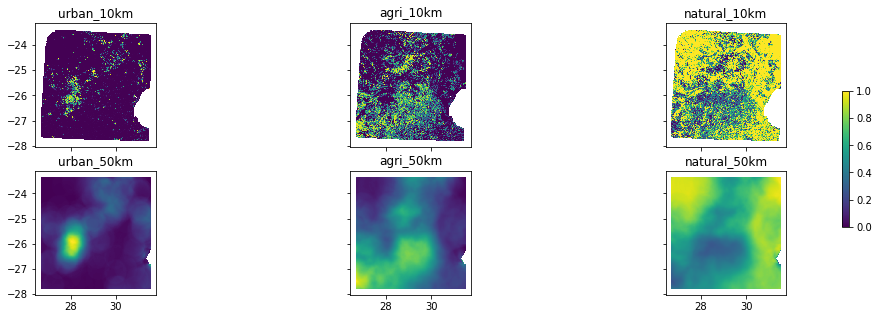

In [12]:
## Plot samples of zonal statistics land cover
fig, axs = plt.subplots(ncols=3,nrows=2, sharex=True, sharey=True, figsize=(20,5))

LC_grid.plot(ax=axs[0,0], column=f'urban_{t}km')
axs[0,0].set_title(f'urban_{t}km')
LC_grid.plot(ax=axs[1,0], column='urban_50km')
axs[1,0].set_title('urban_50km')


LC_grid.plot(ax=axs[0,1], column=f'agri_{t}km')
axs[0,1].set_title(f'agri_{t}km')
LC_grid.plot(ax=axs[1,1], column='agri_50km')
axs[1,1].set_title('agri_50km')


LC_grid.plot(ax=axs[0,2], column=f'natural_{t}km')
axs[0,2].set_title(f'natural_{t}km')
LC_grid.plot(ax=axs[1,2], column='natural_50km')
axs[1,2].set_title('natural_50km')

patch_col = axs[0,0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.5)

### ERA5

In [25]:
# Load data
era5_val_dir = DATA_DIR_VAL/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_val_dir))
era5_eops = [load_tiffs(Path(era5_val_dir)/era5_p, 
                        (FeatureType.DATA, era5_p), 
                        offset=OFFSET, 
                        image_dtype=np.float32,
                        data_source='era5') 
             for era5_p in era5_products]

# Merge into one EOPS
era5_eop = EOPatch(data={'relative_humidity': era5_eops[0].data['relative_humidity'], 
                              'specific_rain_water_content': era5_eops[1].data['specific_rain_water_content'],
                              'wind_u': era5_eops[2].data['wind_u'],
                              'wind_v': era5_eops[3].data['wind_v']},
                        meta_info={'Names_relative_humidity': era5_eops[0].meta_info['Names'],
                                   'Names_specific_rain_water_content':era5_eops[1].meta_info['Names'],
                                   'Names_wind_u': era5_eops[2].meta_info['Names'],
                                   'Names_wind_v': era5_eops[3].meta_info['Names']},
                        timestamp= era5_eops[0].timestamp,
                        bbox= era5_eops[0].bbox)

del era5_eops

## Remove invalid pixels
NO_DATA_VALUE = -32767

era5_eop.data['relative_humidity'][era5_eop.data['relative_humidity'] == NO_DATA_VALUE] = np.nan
era5_eop.data['specific_rain_water_content'][era5_eop.data['specific_rain_water_content'] == NO_DATA_VALUE] = np.nan
era5_eop.data['wind_u'][era5_eop.data['wind_u'] == NO_DATA_VALUE] = np.nan
era5_eop.data['wind_v'][era5_eop.data['wind_v'] == NO_DATA_VALUE] = np.nan

In [26]:
# This function to merge ERA5 products, compute daily mean of ('relative_humidity', 'wind_u', 'wind_v') and daily summation of "specific_rain_water_content"

## location of exported daily mean of ERA5
mean_era5_dir = str(DATA_DIR_VAL/AOIS[0])+'/daily/mean_era5'

## Run merge function
stats_era5(eopatch= era5_eop,
           era5_products= era5_products,
           out_path= mean_era5_dir)

In [27]:
## Resample merged ERA5 to target resolution and same bounding box of target grid (NO2 or PM2.5) - the target resolution will assign automatically based on AOI 
in_path = str(DATA_DIR_VAL/AOIS[0])+'/daily/mean_era5'
out_path = str(DATA_DIR_VAL/AOIS[0])+f'/{model}_data/daily'
resample_era5_to_target(target_bbox=val_eop.bbox, # resample to target bounding box
                       AOI=AOIS[0],
                       model=model,
                       in_path=in_path,
                       out_path=out_path,
                       tiffnames=era5_tiffnames # target dates of ERA5 products
                       )

In [33]:
## Read preprocessed ERA5 
preproc_era5_location = DATA_DIR_VAL/AOIS[0]/f'{model}_data/daily/resampled_era5_{t}km'
era5_products = sorted(os.listdir(preproc_era5_location))

# Load data
era5_val_eops = [load_tiffs(preproc_era5_location/era5_p, 
                        (FeatureType.DATA, era5_p), 
                        offset=OFFSET, 
                        image_dtype=np.float32,
                        data_source='era5') 
             for era5_p in era5_products]

# Merge into one EOPS
era5_val_eop = EOPatch(data={'relative_humidity': era5_val_eops[0].data['relative_humidity'], 
                              'specific_rain_water_content': era5_val_eops[1].data['specific_rain_water_content'],
                              'wind_u': era5_val_eops[2].data['wind_u'],
                              'wind_v': era5_val_eops[3].data['wind_v']},
                        meta_info={'Names_relative_humidity': era5_val_eops[0].meta_info['Names'],
                                   'Names_specific_rain_water_content':era5_val_eops[1].meta_info['Names'],
                                   'Names_wind_u': era5_val_eops[2].meta_info['Names'],
                                   'Names_wind_v': era5_val_eops[3].meta_info['Names']},
                        timestamp= era5_val_eops[0].timestamp,
                        bbox= era5_val_eops[0].bbox)
del era5_val_eops

# IMPORTANT! Missing water pixels are 0. They must be assigned
era5_val_eop.data['specific_rain_water_content'][np.isnan(era5_val_eop.data['specific_rain_water_content'])] = 0

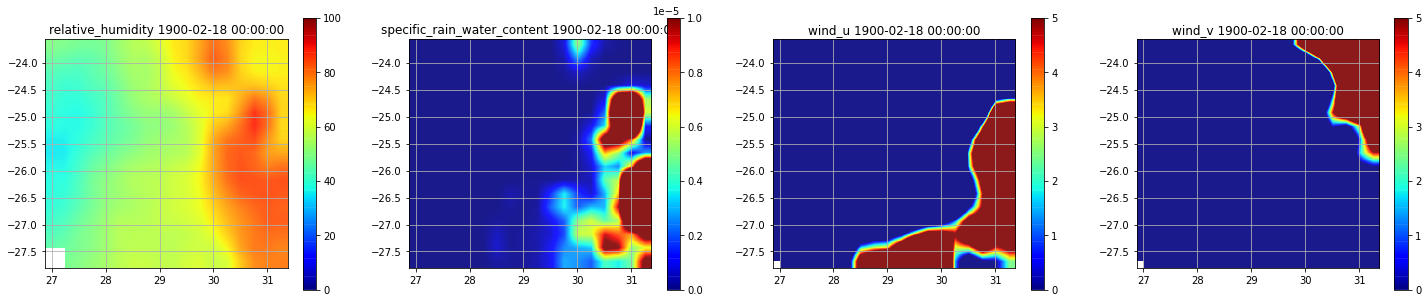

In [34]:
## Plot preprocessed ERA5 10km
fig, axs = plt.subplots(figsize=(25, 5), ncols=4)

time_idx = 0

normalisations = [dict(vmin=0, vmax=100), dict(vmin=0, vmax=0.00001), dict(vmin=0, vmax=5), dict(vmin=0, vmax=5)]

for nn, (fname, norm) in enumerate(zip(era5_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=era5_val_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

### MODIS

In [30]:
modis_val_dir = DATA_DIR_VAL/AOIS[0]/'modis_MCD19A2'
modis_products = sorted(os.listdir(modis_val_dir))

## Load MODIS AOD - Aerosol Optical depth information
modis_eops = [load_tiffs(datapath=modis_val_dir/'MCD19A2_AOD',
                         feature=(FeatureType.DATA, 'AOD'),
                         filename=filename,
                         image_dtype=np.float32,
                         data_source='modis') 
              for filename in sorted(os.listdir(modis_val_dir/'MCD19A2_AOD'))]

## Load MODIS AOD - Optical Depth Quality Index
modis_qa_eops = [load_tiffs(datapath=modis_val_dir/'MCD19A2_AOD_QA',
                            feature=(FeatureType.DATA, 'AOD_QA'),
                            filename=filename,
                            image_dtype=np.float32,
                            data_source='modis') 
                 for filename in sorted(os.listdir(modis_val_dir/'MCD19A2_AOD_QA'))]

In [31]:
#In this step we filtered MODIS pixels & calculate daily statistcs (mean, maximum, minimum) 

# This function to filtere low quailty MODIS pixels using Optical Depth Quality Index band
filter_MODIS(modis_eops,modis_qa_eops)

# This function to Compute Statistics of MODIS to derive a single daily observation (mean, maximum, minimum)
## location of exported statisitcs MODIS
modis_products = ['daily_mean_AOD','daily_maximum_AOD','daily_minimum_AOD']
statistics_modis_dir = str(DATA_DIR_VAL/AOIS[0])+'/daily/statistics_modis'
if not os.path.isdir(statistics_modis_dir):
    os.makedirs(statistics_modis_dir)
    for modis_p in modis_products:
        os.mkdir(statistics_modis_dir + '/' + modis_p)
        
## Run the function to compute statistics MODIS function and export the statistics tiff to a specific directory 
modis_stats(modis_eops, path = statistics_modis_dir)

In [32]:
## Load the daily statistcs MODIS products
modis_eops = [load_tiffs(Path(statistics_modis_dir)/modis, 
                               (FeatureType.DATA, modis),
                               image_dtype=np.float32,
                               data_source='modis')
                    for modis in modis_products]

## Merge them into a single EOPatch
modis_eop = EOPatch(data={'daily_mean_AOD': modis_eops[0].data['daily_mean_AOD'], 
                         'daily_maximum_AOD': modis_eops[1].data['daily_maximum_AOD'],
                               'daily_minimum_AOD': modis_eops[2].data['daily_minimum_AOD'],},
                          meta_info={'tiff_names': modis_eops[0].meta_info['Names']},
                              timestamp=modis_eops[0].timestamp,
                              bbox=modis_eops[0].bbox)
del modis_eops

In [33]:
# This step will fill the mssing pixels in MODIS as following :
## 1- Fill the missing pixels using temporal linear interpolation  
## 2- Loop into the eopatch and asssign the mean value of MODIS observations to the remaining missing pixels
## 3- export the filling MODIS band "Optical_Depth_047" to specific directory

### location of exported filled MODIS band "Optical_Depth_047"
modis_products = ['daily_mean_AOD','daily_maximum_AOD','daily_minimum_AOD']

filled_modis_AOD = str(DATA_DIR_VAL/AOIS[0])+'/daily/filled_stats_modis'
if not os.path.isdir(filled_modis_AOD):
    os.makedirs(filled_modis_AOD)
    for modis_p in modis_products:
        os.mkdir(filled_modis_AOD + '/' + modis_p)
        
### Run the filling function
fill_modis_gaps(modis_eop, modis_products = modis_products, path=filled_modis_AOD)

In [34]:
## Resample daily statistcs MODIS products to target resolution and same bounding box of target grid (NO2 or PM2.5) - the target resolution will assign automatically based on AOI 
in_path = str(DATA_DIR_VAL/AOIS[0])+'/daily/filled_stats_modis'
out_path = str(DATA_DIR_VAL/AOIS[0])+f'/{model}_data/daily'
resample_modis_to_target(target_bbox=val_eop.bbox, # resample to target bounding box
                       AOI=AOIS[0],
                       model=model,
                       in_path=in_path,
                       out_path=out_path,
                        tiffnames=modis_tiffnames # target dates of MODIS products
                         
                        )

In [36]:
# Load resampled MODIS data
modis_val_dir = str(DATA_DIR_VAL/AOIS[0])+f'/{model}_data/daily/resampled_modis_{t}km'
modis_products = sorted(os.listdir(modis_val_dir))

modis_val_eops = [load_tiffs(Path(modis_val_dir)/modis_p, 
                        (FeatureType.DATA, modis_p), 
                        image_dtype=np.float32,
                        data_source='modis')
             for modis_p in modis_products]

# Merge into one EOPS
modis_val_eop = EOPatch(data={'daily_maximum_AOD': modis_val_eops[0].data['daily_maximum_AOD'], 
                              'daily_mean_AOD': modis_val_eops[1].data['daily_mean_AOD'],
                              'daily_minimum_AOD': modis_val_eops[2].data['daily_minimum_AOD']},
                    
                        meta_info={'Names': modis_val_eops[0].meta_info['Names'],
                                   'Names':modis_val_eops[1].meta_info['Names'],
                                   'Names': modis_val_eops[2].meta_info['Names']},
                        timestamp= modis_val_eops[0].timestamp,
                        bbox= modis_val_eops[0].bbox)

del modis_val_eops

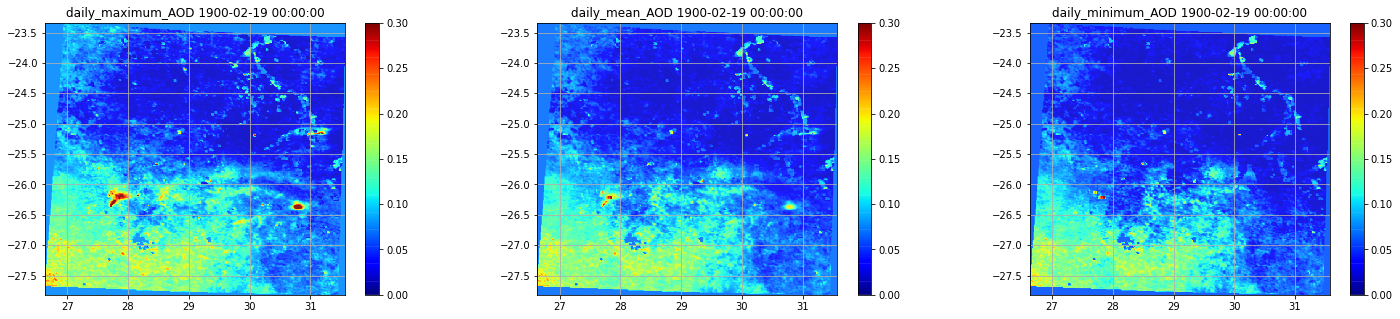

In [37]:
## Plot MODIS Data (mean,maximum,minimium)
fig, axs = plt.subplots(figsize=(25,5), ncols=3)

time_idx = 0



normalisations = [dict(vmin=0, vmax=0.3), dict(vmin=0, vmax=0.3), dict(vmin=0, vmax=0.3)]

for nn, (fname, norm) in enumerate(zip(modis_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=modis_val_eop, 
                      feature=(FeatureType.DATA, fname), 
                      **norm,
                      time_idx = time_idx,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

### Target data - stations
Change 'AOI'  variable for the three provided AOIs, as following:
* `italy` - `Italy`
* `california` - `California`
* `africa` - `South Africa`


In [8]:
# Choose AOI
AOI= 'africa' # italy for Italy , california for California, africa for South Africa

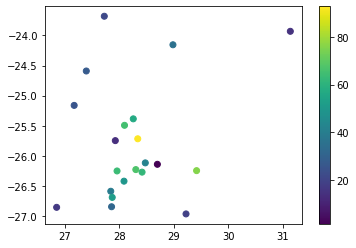

In [9]:
if model == 'NO2':
    # Grouped data
    station = 'NO2'
    no2_gt = gpd.read_file(str(DATA_DIR_TRAIN/AOIS[0]/f'ground_air_quality/{station}/{station}_{AOI}_ground.shp'))
    no2_gt['geometry_wkt'] = no2_gt['geometry'].apply(lambda geom: geom.wkt) 
    no2g_gt = no2_gt.groupby(['SITE_LATIT', 'SITE_LONGI'])
    no2_gt_min = no2g_gt.min()
    no2_gt_min['geometry'] = no2_gt_min['geometry_wkt'].apply(lambda x: wkt.loads(x))
    no2_gt_min.drop(columns='geometry_wkt', inplace=True)
    
    # Plot by date
    dates = no2_gt.Date.unique()
    no2_gt[no2_gt.Date==dates[2]].plot(column="AirQuality",legend=True)
    
elif model == 'PM2_5':
    # Grouped data
    station = 'PM25'
    pm25_gt = gpd.read_file(str(DATA_DIR_TRAIN/AOIS[0]/f'ground_air_quality/{station}/{station}_{AOI}_ground.shp'))
    pm25g_gt = pm25_gt.groupby(['SITE_LONGI','SITE_LATIT'])
    pm25_gt['geometry_wkt'] = pm25_gt['geometry'].apply(lambda geom: geom.wkt) 
    pm25_gt_min = pm25g_gt.min()
    pm25_gt_min['geometry'] = pm25_gt_min['geometry_wkt'].apply(lambda x: wkt.loads(x))
    pm25_gt_min.drop(columns='geometry_wkt', inplace=True)
    

    # Plot by date
    dates = pm25_gt.Date.unique()
    pm25_gt[pm25_gt.Date==dates[2]].plot(column="AirQuality",legend=True)
    


## Extract Training & Validation data

In [38]:
# Extract CAMS data - PM2.5
def extract_cams_pm25(data_path,points, predictor_bbox=None,target_eop=None):
    cams_dir = str(data_path/AOIS[0])+f'/{model}_data/daily'
    cams_df_list = extract_data(predictor= 'cams',     # predictor 
                           points = points,            # Points coordinates to extract data
                           model= model,               # Model (PM2.5, NO2)
                           label='PM2_5',              # Name of CAMS product "PM2_5" 
                           AOI= AOIS[0],               # Area of interest 
                           path=cams_dir,              # Path of CAMS data
                        predictor_bbox=predictor_bbox, # Bounding box of predictor; used to subset points with the target grid boundries when it's smaller than the AOI
                         target_eop=target_eop,        # target eopatch "the eoppatch used to biuld the grid", to extract boundries of target grid , and use it to subset points
 
                               )         
    return cams_df_list


# Extract CAMS data - PM2.5 for training 
training_dataset = [] # list to put all the training dataset inside it

if model == 'NO2':
    cams_df = extract_cams_pm25(data_path = DATA_DIR_TRAIN, points = no2_gt_min,
                                predictor_bbox=cams_train_eop.bbox,
                                target_eop=train_eop
                               )
    
elif model == 'PM2_5':
    cams_df = extract_cams_pm25(data_path = DATA_DIR_TRAIN, points = pm25_gt_min,
                                predictor_bbox=cams_train_eop.bbox,
                                target_eop=train_eop
                               )

    
## Statistics training CAMS PM2.5 - [mean,max,min,std]     
mean_cams_pm25_df = cams_df[0]
max_cams_pm25_df = cams_df[1]
min_cams_pm25_df = cams_df[2]
std_cams_pm25_df = cams_df[3]
     
## Put all training cams datset in list 
training_dataset.append(mean_cams_pm25_df)
training_dataset.append(max_cams_pm25_df)
training_dataset.append(min_cams_pm25_df)
training_dataset.append(std_cams_pm25_df)


# Extract validation CAMS data - PM2.5 
validation_dataset = [] # list to put all the validation dataset inside it

cams_df = extract_cams_pm25(data_path = DATA_DIR_VAL, points = val_target_centroids,                         
                            predictor_bbox=cams_val_eop.bbox,
                            target_eop=val_eop)

## Statistics validation CAMS - [mean,max,min,std] 
mean_cams_pm25_df = cams_df[0]
max_cams_pm25_df = cams_df[1]
min_cams_pm25_df = cams_df[2]
std_cams_pm25_df = cams_df[3]

## Put all validation cams datset in list 
validation_dataset.append(mean_cams_pm25_df)
validation_dataset.append(max_cams_pm25_df)
validation_dataset.append(min_cams_pm25_df)
validation_dataset.append(std_cams_pm25_df)

print(training_dataset[0].shape)
print(validation_dataset[0].shape)

(5612, 5)


In [39]:
# Extract CAMS data -  NO2 surface
def extract_cams_no2(data_path,points, predictor_bbox=None,target_eop=None):
    cams_dir = str(data_path/AOIS[0])+f'/{model}_data/daily'
    cams_df_list = extract_data(predictor= 'cams',   # predictor
                           points = points,          # Points coordinates to extract data
                           model= model,             # Model (PM2.5, NO2)             
                           label='NO2_surface',      # Name of CAMS product "NO2_surface"
                           AOI= AOIS[0],             # Area of interest
                           path=cams_dir,             # Path of CAMS data
                        predictor_bbox=predictor_bbox,# Bounding box of predictor; used to subset points with the target grid boundries when it's smaller than the AOI
                         target_eop=target_eop,       # target eopatch "the eoppatch used to biuld the grid", to extract boundries of target grid , and use it to subset points
 
                               )     
    return cams_df_list

# Extract training CAMS data - NO2 
if model == 'NO2':
    cams_df = extract_cams_no2(data_path = DATA_DIR_TRAIN, points = no2_gt_min,                   
                               predictor_bbox=cams_train_eop.bbox,
                                target_eop=train_eop)

    
elif model == 'PM2_5':
    cams_df = extract_cams_no2(data_path = DATA_DIR_TRAIN, points = pm25_gt_min,
                               predictor_bbox=cams_train_eop.bbox,
                                target_eop=train_eop)

    
## Statistics training CAMS NO2 surface - [mean,max,min,std] 
mean_cams_no2_df = cams_df[0]
max_cams_no2_df = cams_df[1]
min_cams_no2_df = cams_df[2]
std_cams_no2_df = cams_df[3]
    
## Add CAMS data - NO2 surface to training list
training_dataset.append(mean_cams_no2_df)
training_dataset.append(max_cams_no2_df)
training_dataset.append(min_cams_no2_df)
training_dataset.append(std_cams_no2_df)


# Extract validation CAMS data -  NO2 surface
cams_df = extract_cams_no2(data_path = DATA_DIR_VAL, points = val_target_centroids,                    
                           predictor_bbox=cams_val_eop.bbox,
                            target_eop=val_eop)

## Statistics validation CAMS - [mean,max,min,std] 
mean_cams_no2_df = cams_df[0]
max_cams_no2_df = cams_df[1]
min_cams_no2_df = cams_df[2]
std_cams_no2_df = cams_df[3]

## Add CAMS data - NO2 surface to validation list
validation_dataset.append(mean_cams_no2_df)
validation_dataset.append(max_cams_no2_df)
validation_dataset.append(min_cams_no2_df)
validation_dataset.append(std_cams_no2_df)

print(training_dataset[7].shape)
print(validation_dataset[7].shape)

(5612, 5)


In [40]:
# Extract S5P data -  NO2 
def extract_s5p_no2(data_path,points, predictor_bbox=None,target_eop=None):
    s5p_dir = str(data_path/AOIS[0])+f'/{model}_data/daily'
    no2_df = extract_data(predictor= 's5p',                   # predictor 
                           points = points,                   # Points coordinates to extract data
                           model= model,                      # Model (PM2.5, NO2)
                           label='NO2',                       # Name of S5P product "NO2"
                           AOI= AOIS[0],                      # Area of interest 
                           path=s5p_dir,                      # Path of S5P data
                          predictor_bbox=predictor_bbox,      # Bounding box of predictor; used to subset points with the target grid boundries when it's smaller than the AOI
                         target_eop=target_eop,               # target eopatch "the eoppatch used to biuld the grid", to extract boundries of target grid , and use it to subset points
                         )
    return no2_df

# Extract training S5P data - NO2 
if model == 'NO2':
    no_df = extract_s5p_no2(data_path = DATA_DIR_TRAIN, points = no2_gt_min,                
                            predictor_bbox=s5p_train_eop.bbox,
                            target_eop=train_eop)
    
elif model == 'PM2_5':
    no_df = extract_s5p_no2(data_path = DATA_DIR_TRAIN, points = pm25_gt_min,
                            predictor_bbox=s5p_train_eop.bbox,
                            target_eop=train_eop)


## Add S5P data - NO2 to training list
training_dataset.append(no_df)

# Extract validation S5P data - PM2.5 
no_df = extract_s5p_no2(data_path = DATA_DIR_VAL, 
                        points = val_target_centroids, 
                        predictor_bbox=s5p_val_eop.bbox,
                        target_eop=val_eop)

## Add S5P data - NO2  to validation list
validation_dataset.append(no_df)

print(training_dataset[8].shape)
print(validation_dataset[8].shape)

(5413, 5)


In [41]:
# Extract S5P data -  UV AEROSOL INDEX' 
def extract_s5p_aerosol(data_path,points, predictor_bbox=None,target_eop=None):
    s5p_dir = str(data_path/AOIS[0])+f'/{model}_data/daily'
    uv_aerosol_df = extract_data(predictor= 's5p',                # predictor 
                                 points = points,                 # Points coordinates to extract data
                                 model= model,                    # Model (PM2.5, NO2)
                                 label='UV_AEROSOL_INDEX',        # Name of S5P product "UV_AEROSOL_INDEX"
                                 AOI= AOIS[0],                    # Area of interest 
                                 path=s5p_dir,                    # Path of S5P data
                                 predictor_bbox=predictor_bbox,   # Bounding box of predictor; used to subset points with the target grid boundries when it's smaller than the AOI
                                 target_eop=target_eop,           # target eopatch "the eoppatch used to biuld the grid", to extract boundries of target grid , and use it to subset points
                                )
    return uv_aerosol_df

# Extract training S5P data - NO2 
if model == 'NO2':
    uv_aerosol_df = extract_s5p_aerosol(data_path = DATA_DIR_TRAIN, points = no2_gt_min,                                    
                                        predictor_bbox=s5p_train_eop.bbox,
                                        target_eop=train_eop)
    
elif model == 'PM2_5':
    uv_aerosol_df = extract_s5p_aerosol(data_path = DATA_DIR_TRAIN, points = pm25_gt_min,
                                        predictor_bbox=s5p_train_eop.bbox,
                                        target_eop=train_eop)


## Add S5P data - 'UV_AEROSOL_INDEX' to training list
training_dataset.append(uv_aerosol_df)

# Extract validation S5P data - 'UV_AEROSOL_INDEX' 
uv_aerosol_df = extract_s5p_aerosol(data_path = DATA_DIR_VAL, 
                                    points = val_target_centroids, 
                                    predictor_bbox=s5p_val_eop.bbox,
                                    target_eop=val_eop)

## Add S5P data - NO2  to validation list
validation_dataset.append(uv_aerosol_df)

print(training_dataset[9].shape)
print(validation_dataset[9].shape)

(5397, 5)


In [42]:
# Extract ERA5 - this function will extract the observation of the same day and the previous day
# this function will create two columns (one for the ERA5 value of the same day and another column for the ERA5 value of the previous day )

def extract_era5(data_path,points, predictor_bbox=None,target_eop=None):
    # Path of ERA5 data
    era5_dir = str(data_path/AOIS[0])+f'/{model}_data/daily'
    ## Run the extract ERA5 function
    era5_df = extract_data(predictor= 'era5',            ## predictor
                           points = points,              ## Points coordinates to extract data
                           model= model,                 ## Model (PM2.5, NO2)
                           AOI= AOIS[0],                 ## Area of interest
                           path=era5_dir,                ## Path of ERA5 data
                           predictor_bbox=predictor_bbox, ## Bounding box of predictor; used to subset points with the target grid boundries when it's smaller than the AOI
                           target_eop=target_eop          ## target eopatch "the eoppatch used to biuld the grid", to extract boundries of target grid , and use it to subset points        
                          )
    return era5_df

# Extract training CAMS data - NO2 
if model == 'NO2':
    era5_df = extract_era5(data_path = DATA_DIR_TRAIN,
                           points = no2_gt_min, 
                           predictor_bbox=era5_train_eop.bbox,
                           target_eop=train_eop)
    
elif model == 'PM2_5':
    era5_df = extract_era5(data_path = DATA_DIR_TRAIN,
                           points = pm25_gt_min, 
                           predictor_bbox=era5_train_eop.bbox,
                           target_eop=train_eop)
    
## Training ERA5 products
relative_humidity_df = era5_df[0]
srwc_df = era5_df[1]
wind_u_df = era5_df[2]
wind_v_df = era5_df[3] 

## Add Training ERA5 to the training lists
training_dataset.append(relative_humidity_df)
training_dataset.append(srwc_df)
training_dataset.append(wind_u_df)
training_dataset.append(wind_v_df)


# Extract validation ERA5 data 
era5_df = extract_era5(data_path = DATA_DIR_VAL, points = val_target_centroids, predictor_bbox=era5_val_eop.bbox, target_eop=val_eop)

## Validation ERA5 products
relative_humidity_df = era5_df[0]
srwc_df = era5_df[1]
wind_u_df = era5_df[2]
wind_v_df = era5_df[3] 

## Add CAMS data - NO2 surface to validation list
validation_dataset.append(relative_humidity_df)
validation_dataset.append(srwc_df)
validation_dataset.append(wind_u_df)
validation_dataset.append(wind_v_df)

print(training_dataset[13].shape)
print(validation_dataset[13].shape)

(5278, 6)


In [43]:
# Extract MODIS 
def extract_modis(data_path,points, predictor_bbox=None,target_eop=None):
    # Path of MODIS data
    modis_dir = str(data_path/AOIS[0])+f'/{model}_data/daily'
    ## Run the extract MODIS function
    modis_df = extract_data(predictor= 'modis',          ## predictor
                           points = points,              ## Points coordinates to extract data
                           model= model,                 ## Model (PM2.5, NO2)
                           AOI= AOIS[0],                 ## Area of interest
                           path=modis_dir,                ## Path of S5P data
                           predictor_bbox=predictor_bbox, ## Bounding box of predictor; used to subset points with the target grid boundries when it's smaller than the AOI
                           target_eop=target_eop          ## target eopatch "the eoppatch used to biuld the grid", to extract boundries of target grid , and use it to subset points        
                          )
    return modis_df

# Extract training MODIS data 
if model == 'NO2':
    modis_df = extract_modis(data_path = DATA_DIR_TRAIN,
                             points = no2_gt_min,
                             predictor_bbox=modis_train_eop.bbox,
                             target_eop=train_eop)
    
elif model == 'PM2_5':
    modis_df = extract_modis(data_path = DATA_DIR_TRAIN,
                             points = pm25_gt_min, 
                             predictor_bbox=modis_train_eop.bbox,
                             target_eop=train_eop)
    
## Statistics training MODIS - [mean,max,min] 
modis_mean_df = modis_df[0]
modis_min_df = modis_df[1]
modis_max_df = modis_df[2]

## Add Training MODIS to the training lists
training_dataset.append(modis_mean_df)
training_dataset.append(modis_min_df)
training_dataset.append(modis_max_df)


# Extract validation MODIS data 
modis_df = extract_modis(data_path = DATA_DIR_VAL, points = val_target_centroids, predictor_bbox=modis_val_eop.bbox, target_eop=val_eop)

## Statistics validation MODIS - [mean,max,min] 
modis_mean_df = modis_df[0]
modis_min_df = modis_df[1]
modis_max_df = modis_df[2] 

## Add validation MODIS to validation list
validation_dataset.append(modis_mean_df)
validation_dataset.append(modis_min_df)
validation_dataset.append(modis_max_df)


print(training_dataset[16].shape)
print(validation_dataset[16].shape)

(5612, 4)


In [44]:
# Extract land cover - zonal statistcs
def extract_land_cover(data_path,points):
    DATA_SET = []
    land_cover_stats_dir = str(data_path/AOIS[0])+f'/{land_cover_file}/zonal_stats/{model}'
    lc_df = extract_data(predictor= 'lc',
                         points = points, 
                         model= model,
                         label= 'LC', ## (feature_name_LC = 'LC') It should match the feature name of LC that used when copute zonal_stats of land ocvoer
                         AOI= AOIS[0],
                         path=land_cover_stats_dir)

    ## These common Land cover between all AOIs
    agri_10km_df = lc_df[0]
    agri_50km_df = lc_df[1]
    natural_10km_df = lc_df[2]
    natural_50km_df = lc_df[3]
    urban_10km_df = lc_df[4]
    urban_50km_df = lc_df[5]

    ## Add them to the data lists
    DATA_SET.append(agri_10km_df), DATA_SET.append(agri_50km_df),DATA_SET.append(natural_10km_df)
    DATA_SET.append(natural_50km_df), DATA_SET.append(urban_10km_df),DATA_SET.append(urban_50km_df)

    ## those diffirent LC based on the AOI 
    if AOIS[0] == 'California':
        water_10km_df = lc_df[6]
        water_50km_df = lc_df[7]
        ## Add them to the data lists
        DATA_SET.append(water_10km_df), DATA_SET.append(water_50km_df)

    elif AOIS[0] == 'South_Africa':
        indtrans_10km_df = lc_df[6]
        indtrans_50km_df = lc_df[7]
        ## Add them to the data lists
        DATA_SET.append(indtrans_10km_df), DATA_SET.append(indtrans_50km_df)

    elif AOIS[0] == 'Italy':
        indtrans_10km_df = lc_df[6]
        indtrans_50km_df = lc_df[7]
        water_10km_df = lc_df[8]
        water_50km_df = lc_df[9]
        ## Add them to the data lists
        DATA_SET.append(indtrans_10km_df), DATA_SET.append(indtrans_50km_df)
        DATA_SET.append(water_10km_df), DATA_SET.append(water_50km_df)
            
    return DATA_SET


In [45]:
# Extract training zonal stats land cover  
if model == 'NO2':
    train_land_cover = extract_land_cover(data_path = DATA_DIR_TRAIN, points = no2_gt_min)

elif model == 'PM2_5':
    train_land_cover = extract_land_cover(data_path = DATA_DIR_TRAIN, points = pm25_gt_min)

## Add Training LAND COVER to the training data list
training_dataset = training_dataset + train_land_cover

# Extract validation zonal stats land cover 
val_land_cover = extract_land_cover(data_path = DATA_DIR_VAL, points = val_target_centroids)

## Add validation LAND COVER to the validation data list
validation_dataset = validation_dataset + val_land_cover

print(training_dataset[18].shape)
print(validation_dataset[18].shape)

(61, 3)


### Create dataset
 This step to merge the datset based on dates & coordinates of stations

Change 'AOI' variable for the three provided AOIs, as following:

* `Italy` - `Italy`
* `usa` - `California`
* `SA` - `South Africa`

In [12]:
AOI = 'SA' # "Italy" for Italy, "usa" for California, "SA" for South Africa


In [52]:
## This function to merge datset with stations data based on date & coordinates of observations
def Create_dataset(points, data,dates=None):
    dataset_df = create_dataset(target_points= points, # stations points (coordinates & dates)
                               model = model,         # Model (PM2.5/NO2)
                               AOI= AOIS[0],          # Area of interest
                               dates=dates,           # dates of target images (filter the dataset to these dates)
                               dataset= data          # Dataset to merge (training/validation)
                              )
    return dataset_df

# Create training dataset 
if model == 'NO2':
    ## This function to merge datset based on date & coordinates of observations
    train_df = Create_dataset(points=no2_gt, data= training_dataset)

elif model == 'PM2_5':
    train_df = Create_dataset(points=pm25_gt, data= training_dataset)
    
print(train_df.shape)
print(train_df.columns)

(1513, 36)
Index(['Date', 'lat', 'lon', 'AirQuality', 'geometry', 'geometry_wkt', 'date',
       's5p_NO2', 'hour', 'mean_cams_PM2_5', 'maximum_cams_PM2_5',
       'minimum_cams_PM2_5', 'std_cams_PM2_5', 'mean_cams_NO2_surface',
       'maximum_cams_NO2_surface', 'minimum_cams_NO2_surface',
       'std_cams_NO2_surface', 'relative_humidity', 'p_rh',
       'specific_rain_water_content', 'p_srwc', 'wind_u', 'p_wind_u', 'wind_v',
       'p_wind_v', 'daily_mean_AOD', 'daily_minimum_AOD', 'daily_maximum_AOD',
       'agri_1km', 'agri_50km', 'natural_1km', 'natural_50km', 'urban_1km',
       'urban_50km', 'indtrans_1km', 'indtrans_50km'],
      dtype='object')


In [13]:
# Create validation dataset
if model == 'NO2':
    ## NO2 target dates - to filter the data to the target dates 
    dates = pd.read_csv(f'submission_date/{AOI}-date-NO2.txt')
    
    ## Create validation dataset
    val_df = Create_dataset(points=val_target_centroids, data= validation_dataset, dates=dates)

elif model == 'PM2_5':
    ## PM2.5 target dates - to filter the data to the target dates
    dates = pd.read_csv(f'submission_date/{AOI}-date-PM25.txt')
    
    ## Create validation dataset
    val_df = Create_dataset(points=val_target_centroids, data= validation_dataset, dates=dates)
    
print(val_df.shape )
print(val_df.columns)

(1999914, 33)
Index(['lon', 'lat', 's5p_NO2', 'date', 'hour', 'time', 'mean_cams_PM2_5',
       'maximum_cams_PM2_5', 'minimum_cams_PM2_5', 'std_cams_PM2_5',
       'mean_cams_NO2_surface', 'maximum_cams_NO2_surface',
       'minimum_cams_NO2_surface', 'std_cams_NO2_surface', 'relative_humidity',
       'p_rh', 'specific_rain_water_content', 'p_srwc', 'wind_u', 'p_wind_u',
       'wind_v', 'p_wind_v', 'daily_mean_AOD', 'daily_minimum_AOD',
       'daily_maximum_AOD', 'agri_1km', 'agri_50km', 'natural_1km',
       'natural_50km', 'urban_1km', 'urban_50km', 'indtrans_1km',
       'indtrans_50km'],
      dtype='object')


## Modelling & Validation

In [53]:
# X and Y parts
train_df = train_df.drop(['Date', 'lat', 'lon', 'geometry', 'geometry_wkt', 'date', 'hour'], axis=1)

train_X = np.array(train_df.drop(['AirQuality'], axis=1))
train_y = np.array(train_df['AirQuality'])

### Random Forest

In [54]:
# Parameter grid:
max_depth = [1, 5, 10, None]
min_samples_split = [2, 5, 10]
max_features = [3, 5, 10]

hyperF = dict(max_depth = max_depth,  
              min_samples_split = min_samples_split,
              max_features = max_features)
    
# Define model
rf = RandomForestRegressor(random_state=1, n_estimators=500) 
#Parameter grid search
gridF = GridSearchCV(rf, hyperF, cv=5, verbose=0, n_jobs = -1)
gridF.fit(train_X, train_y)
print(gridF.best_params_)

# Fit best model, derive predictions and save to disk
best_rf = gridF.best_estimator_
best_rf.fit(train_X, train_y)
joblib.dump(best_rf, f'trained_models/{AOIS[0]}_{model}_rf_model.sav')
pred_y = best_rf.predict(train_X)

{'max_depth': 5, 'max_features': 3, 'min_samples_split': 5}


In [55]:
importances = list(best_rf.feature_importances_)
feature_list = train_df.columns.drop('AirQuality')
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: indtrans_1km         Importance: 0.11
Variable: urban_50km           Importance: 0.1
Variable: mean_cams_PM2_5      Importance: 0.09
Variable: natural_1km          Importance: 0.09
Variable: std_cams_PM2_5       Importance: 0.08
Variable: agri_1km             Importance: 0.07
Variable: agri_50km            Importance: 0.07
Variable: natural_50km         Importance: 0.07
Variable: maximum_cams_PM2_5   Importance: 0.06
Variable: indtrans_50km        Importance: 0.06
Variable: urban_1km            Importance: 0.05
Variable: s5p_NO2              Importance: 0.04
Variable: relative_humidity    Importance: 0.02
Variable: wind_u               Importance: 0.02
Variable: minimum_cams_PM2_5   Importance: 0.01
Variable: p_rh                 Importance: 0.01
Variable: specific_rain_water_content Importance: 0.01
Variable: p_wind_u             Importance: 0.01
Variable: wind_v               Importance: 0.01
Variable: p_wind_v             Importance: 0.01
Variable: daily_mean_AOD       Imp

Resubstitution MAE: 6.6e-05
Resubstitution RMSE: 8.8e-05
Resubstitution R2: 0.659


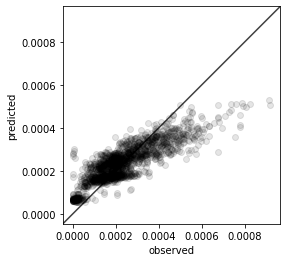

In [56]:
# Resubstitution error
print('Resubstitution MAE:', round(metrics.mean_absolute_error(train_y, pred_y), 6))
print('Resubstitution RMSE:', round(np.sqrt(metrics.mean_squared_error(train_y, pred_y)), 6))
print('Resubstitution R2:', round(metrics.r2_score(train_y, pred_y), 3))

fig, ax = plt.subplots()
ax.scatter(train_y, pred_y, color='black', alpha=0.1)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("observed")
plt.ylabel("predicted")
plt.show()

## Prediction

In [14]:
## validation data to predict target  dates
mod = joblib.load(f'trained_models/{AOIS[0]}_{model}_rf_model.sav')
val_X = np.array(val_df.drop(['lon','lat','date','hour', 'time'], axis=1))

# Predict
predicted = mod.predict(val_X)
val_df['pred'] = predicted
pred_df = val_df[['pred','date','lon','lat']]

# Put the results into geodataframe
pred_gdf = gpd.GeoDataFrame(pred_df['pred'], geometry=gpd.points_from_xy(pred_df.lon, pred_df.lat))
pred_gdf['date'] = pred_df['date']
pred_gdf['lon'] = round(pred_gdf.geometry.x, 4)
pred_gdf['lat'] = round(pred_gdf.geometry.y, 4)

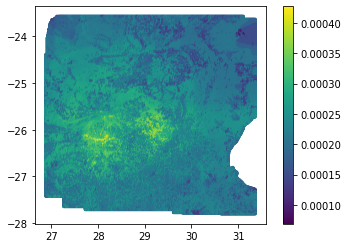

In [15]:
# Visualize raw predictions by day
i = 0
pred_plot_gdf = pred_gdf[pred_gdf['date'] == list(dates['date'])[i]]
pred_plot_gdf.plot(column='pred', legend=True, markersize=4);

## Residual Correction & Calibration

The model calibrated by two steps, the first step was model residual error correction by aggregate the predicted pixels that constitute the low-resolution pixel in the mean daily input (NO2/PM2.5), then compute the difference between them and distribute the difference equally between the predicted pixels. The second step was calibrating the corrected predictions with hourly NO2/PM2.5 data, by make the constitute corrected predictions and hourly low-resolution pixels to have same average.

In [16]:
## Create submission folders
sub_dir = Path('val-submission')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(sub_dir/aoi/product):
            os.makedirs(sub_dir/aoi/product)

## Create visualize folders
viz_dir = Path('val-viz')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(viz_dir/aoi/product):
            os.makedirs(viz_dir/aoi/product)

In [17]:
# Indicator in the original grid 
grid_ID = copy.deepcopy(val_orig_grid)
grid_ID['ID'] = list(range(0, val_orig_grid.shape[0]))

# Spatial join with centroids
val_target_centroids['id'] = 1 
cal_gdf = gpd.sjoin(val_target_centroids, grid_ID, how="inner", op='intersects')
cal_gdf['lon'] = round(val_target_centroids.geometry.x, 4)
cal_gdf['lat'] = round(val_target_centroids.geometry.y, 4)

Change 'mask' variable  to crop the product to same AOI bounding box, as following:

* `North_Italy` - `Italy`
* `California` - `California`
* `South_Africa` - `South Africa`

* Note: this step may takes time 

In [18]:
mask = 'South_Africa' # "North_Italy" for Italy, "California" for California and "South_Africa" for South Africa.

bbox_mask = gpd.read_file(f'AOIs_bboxes/{AOIS[0]}/{mask}_test.shp')
bbox_mask.to_crs(epsg=4326, inplace=True)
bbox_mask.to_file(f'AOIs_bboxes/{AOIS[0]}/{mask}-bbox-wgs84.shp', driver='ESRI Shapefile')

In [20]:
if model == 'NO2':
    ## Path of billinear resampled NO2 to impute the missing pixels
    resampled_path = DATA_DIR_VAL/AOIS[0]/f'{model}_data/daily/resampled_s5p_{t}km'

    ## Path of daily mean NO2 - to do residual correction
    daily_mean_path = DATA_DIR_VAL/AOIS[0]/'daily/mean_s5p'
  
    ## Path of coarse resolution of hourly NO2 - to do calibration
    original_path = DATA_DIR_VAL/AOIS[0]/'sentinel5P'

    ## Run the correction and calibration function
    calibrate(predictions = pred_gdf,              # predictions (Geodataframe)
              eopatch = val_eop,                   # NO2/PM2.5 eopatch to find the boundaries of PM2.5/NO2 product , used to rasterize the final predictions
              dates = dates,                       # target dates
              original_grid = cal_gdf ,            # Original grid with target pixels centroids
              target_grid = val_target_grid,       # Target grid, it will used to rasterize the final predictions
              resampled_dir = resampled_path,     # Path of billinear resampled input NO2/PM2.5 to impute the missing pixels from it before correction and calibration
              daily_mean_dir = daily_mean_path,    # Path of daily mean cams (to do residual correction)
              original_dir = original_path,       # Path of coarse resolution of hourly NO2/PM2.5 (to do calibration)
              mask = mask,                         # Mask to crop the product to the AOI bounding box
              AOI = AOIS[0],                       # Area of interest
              model = model,                       # Model NO2/PM2.5
              sub_dir= sub_dir,                    # Path of submission folder
              viz_dir = viz_dir,                   # Path of visualization folder
              
             )
    
elif model == 'PM2_5':
    ## Path of billinear resampled input PM 2.5 to impute the missing pixels
    resampled_path = DATA_DIR_VAL/AOIS[0]/f'{model}_data/daily/resampled_mean_cams_{t}km'
    
    ## Path of daily mean PM2.5 - to do residual correction
    daily_mean_path = DATA_DIR_VAL/AOIS[0]/'daily/mean_cams'
    
    # Path of coarse resolution of PM2.5 to do calibrtion
    original_path = DATA_DIR_VAL/AOIS[0]/'CAMS'
    
    ## Run the correction and calibration function
    calibrate(predictions = pred_gdf,              # predictions (Geodataframe)
              eopatch = val_eop,                   # NO2/PM2.5 eopatch to find the boundaries of PM2.5/NO2 product , used to rasterize the final predictions
              dates = dates,                       # target dates
              original_grid = cal_gdf ,            # Original grid with target pixels centroids
              target_grid = val_target_grid,       # Target grid, it will used to rasterize the final predictions
              resampled_dir = resampled_path,      # Path of billinear resampled input NO2/PM2.5 to impute the missing pixels from it before correction and calibration
              daily_mean_dir = daily_mean_path,    # Path of daily mean cams (to do residual correction)
              original_dir = original_path,        # Path of coarse resolution of hourly NO2/PM2.5 (to do calibration)
              mask = mask,                         # Mask to crop the product to the AOI bounding box
              AOI = AOIS[0],                       # Area of interest
              model = model,                       # Model NO2/PM2.5
              sub_dir= sub_dir,                    # Path of submission folder
              viz_dir = viz_dir,                   # Path of visualization folder
              
             )
    

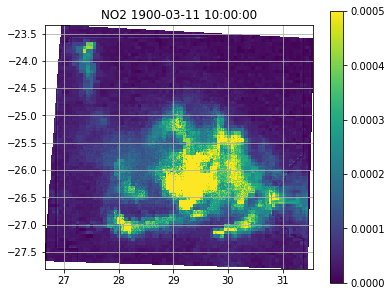

In [23]:
## load final products NO2/PM2.5

if model == 'NO2':
    
    # Choose the day and time
    i = 0
    day = dates['date'][i]
    hour = dates['time'][i]
    
    upscaled_dir = Path(f'val-viz/{AOIS[0]}/NO2')
    upscaled_img = load_tiffs(Path(upscaled_dir), (FeatureType.DATA, 'NO2'),filename = f'S5P_NO2__OFFL_L2_day{day}_T{hour[1:3]}.tif', offset=OFFSET) 

    time_idx =0
    fig, ax = plt.subplots(figsize=(6,5))
    fh = draw_feature(ax=ax, eopatch=upscaled_img,
                      feature=(FeatureType.DATA, 'NO2'),
                      time_idx=time_idx,
                      vmin=0, vmax=0.0005)
    fig.colorbar(fh, ax=ax);
    
elif model == 'PM2_5':
    upscaled_dir = Path(f'val-viz/{AOIS[0]}/PM2.5')
    upscaled_img = load_tiffs(upscaled_dir,
                              (FeatureType.DATA, 'PM2_5'),
                              offset=OFFSET,
                              data_source='cams')
    time_idx = 1
    fig, ax = plt.subplots(figsize=(6,5))
    fh = draw_feature(ax=ax, eopatch=upscaled_img,
                      feature=(FeatureType.DATA, 'PM2_5'),
                      time_idx=time_idx,
                      vmin=0, vmax=30)
    fig.colorbar(fh, ax=ax);